In [403]:
import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

print(common_variable.sections())
print(common_variable['database']['module_path'])
print(common_variable['database']['DB_BASE'])

import sys
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *

import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from parse import parse
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from glob import glob
from tqdm import tqdm_notebook

['database', 'mlflow', 'font']
/media/myungsungkwak/msdisk/docrv2_sroie/modules/database/
/media/myungsungkwak/msdisk/docrv2_data/DB/


In [404]:
def get_coords_from_image(txt_file):
    
    lps = []
    with open(txt_file, 'r') as f:
        coords_data = f.read().split('\n')
        for ii in range(len(coords_data)):
            if len(coords_data[ii]) > 0:
                ps = parse('{},{},{},{},{},{},{},{},{}', coords_data[ii])
                ps = list(ps)
                ps[:-1] = list(map(int, ps[:-1]))
                lps.append(ps)
    return lps

def calculate_coords(coords_table, crop_idx, crop_xy):
    
    ii = 0
    while True:
        coords_table[ii][0] = coords_table[ii][0] - crop_xy[0] # x1
        coords_table[ii][1] = coords_table[ii][1] - crop_xy[1] # y1
        coords_table[ii][2] = coords_table[ii][2] - crop_xy[0] # x2
        coords_table[ii][3] = coords_table[ii][3] - crop_xy[1] # y2
        coords_table[ii][4] = coords_table[ii][4] - crop_xy[0] # x3
        coords_table[ii][5] = coords_table[ii][5] - crop_xy[1] # y3
        coords_table[ii][6] = coords_table[ii][6] - crop_xy[0] # x4
        coords_table[ii][7] = coords_table[ii][7] - crop_xy[1] # y4

        ii = ii + 1
        if ii == len(coords_table):
            break
    return coords_table


def get_crop_image(img_path, coords, crop_size=(256,128), num_images=1):
    
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]

    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords)) 
    transpose_y1_coords = list(map(int, transpose_y1_coords)) 

    sample_list = []
    coords_list = []
    for idx in range(num_images):
        while True:
            base_idx = np.random.choice(len(transpose_x1_coords), 1, replace=False)[0]
            base_x1 = transpose_x1_coords[base_idx]
            base_y1 = transpose_y1_coords[base_idx]

            new_x3 = base_x1 + crop_size[0]
            new_y3 = base_y1 + crop_size[1]

            if (new_x3 > o_width) or (new_y3 > o_height):
                continue
            crop_img = img.crop((base_x1, base_y1, new_x3, new_y3))
            copy_coords = copy.deepcopy(coords)
            crop_coords = calculate_coords(copy_coords, base_idx, (base_x1, base_y1))
            
            coords_list.append(crop_coords)
            sample_list.append(crop_img)
            del crop_coords[:][:]
            break
    return sample_list, coords_list, base_idx, (base_x1,base_y1)

def create_database(db_idx):

    path = common_variable['database']['DB_BASE']
    os.makedirs(path, exist_ok=True)

    name = 'd2gan_train_task12_crop_%04d' % db_idx
    description = 'data db from train_task12 as crop images 256x128'
    datadb = create_data_db(path=path, name=name, description=description, data_class='DATA')
    
    return datadb

def update_database(datadb, imgs, coords, refname, db_start_idx):

    for idx, img in enumerate(imgs):
        chars = []
        transpose_chars = np.transpose(coords[idx])[8]
        transpose_chars = list(map(str, transpose_chars))
        chars.append(transpose_chars)


        char_table = pd.DataFrame(coords[idx])
        char_table.rename(columns={0:'x1', 1:'y1', 2:'x2', 3:'y2', 4:'x3',
                                   5:'y3', 6:'x4', 7:'y4', 8:'char'}, inplace=True)
        char_table.x1 = char_table.x1.astype(int)
        char_table.y1 = char_table.y1.astype(int)
        char_table.x2 = char_table.x2.astype(int)
        char_table.y2 = char_table.y2.astype(int)
        char_table.x3 = char_table.x3.astype(int)
        char_table.y3 = char_table.y3.astype(int)
        char_table.x4 = char_table.x4.astype(int)
        char_table.y4 = char_table.y4.astype(int)
        
        update_data(datadb, 
                    index=db_start_idx+idx, 
                    label='task12', 
                    image=img, 
                    text=None, 
                    ref=refname, 
                    char_c=char_table,
                    char=chars[0])

In [368]:
# refresh_main_db()

+---------------------------+----------------------------------------------------------------------+
| Key                       | Value                                                                |
+---------------------------+----------------------------------------------------------------------+
| denoise_0001              | /media/myungsungkwak/msdisk/docrv2_data/DB/denoise_0001              |
| style_B                   | /media/myungsungkwak/msdisk/docrv2_data/DB/style_B                   |
| style_real_00000          | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00000          |
| style_real_00001          | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00001          |
| style_real_00002          | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00002          |
| style_real_00003          | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00003          |
| style_real_00004          | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00004  

['style_real_00003',
 'train_task12_new_0001',
 'style_B',
 'style_real_00000',
 'style_real_00002',
 'test_task12_origin_0001',
 'style_real_00001',
 'test_task12_image_db',
 'denoise_0001',
 'style_real_00004',
 'test_task12_image_db_0001',
 'test_task12_new_0002']

In [408]:
datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task1_crop/'
img_files = glob(datadir+'*.jpg')
txt_files = glob(datadir+'*.txt')

crop_images = []
coords_table = []

print(len(img_files))

datadb = create_database(100)
num_images = 5
db_start_idx = 0
#for idx in tqdm(range(len(img_files))):
for idx in tqdm(range(2)):
    # print(idx, " : ", img_files[idx])
    refname = os.path.basename(img_files[idx])[:-4]
    txt_filepath = os.path.join(datadir, refname+'.txt')
    coords_table.append(get_coords_from_image(txt_filepath))
    crop_img, crop_coords, crop_idx, crop_xy = get_crop_image(img_files[idx],
                                                              coords_table[idx],
                                                              crop_size=(256,128),
                                                              num_images=num_images)
    update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
    db_start_idx = db_start_idx + num_images
    
    del coords_table[:][:]


  0%|          | 0/2 [00:00<?, ?it/s]

626



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


In [399]:
refresh_main_db()

+------------------------------+-------------------------------------------------------------------------+
| Key                          | Value                                                                   |
+------------------------------+-------------------------------------------------------------------------+
| d2gan_train_task12_crop_0000 | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0000 |
| d2gan_train_task12_crop_0001 | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0001 |
| d2gan_train_task12_crop_0002 | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0002 |
| denoise_0001                 | /media/myungsungkwak/msdisk/docrv2_data/DB/denoise_0001                 |
| style_B                      | /media/myungsungkwak/msdisk/docrv2_data/DB/style_B                      |
| style_real_00000             | /media/myungsungkwak/msdisk/docrv2_data/DB/style_real_00000             |
| style_real_00001             | /med

['style_real_00003',
 'd2gan_train_task12_crop_0002',
 'train_task12_new_0001',
 'style_B',
 'style_real_00000',
 'style_real_00002',
 'test_task12_origin_0001',
 'style_real_00001',
 'test_task12_image_db',
 'denoise_0001',
 'd2gan_train_task12_crop_0000',
 'style_real_00004',
 'd2gan_train_task12_crop_0001',
 'test_task12_image_db_0001',
 'test_task12_new_0002']

In [333]:

import cv2
def compute_word_maps(heatmap, image_height, image_width, lines, heatmap_affinity=None, 
                      offset=(0,0), descale=2, make_channel=False):
    # if heatmap_affinity is None:
    #     heatmap_affinity = heatmap

    textmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')
    # linkmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')

    src = np.array([[0, 0], [heatmap.shape[1], 0], [heatmap.shape[1], heatmap.shape[0]], [0, heatmap.shape[0]]]).astype(
        'float32')

    for line in lines:
        previous_link_points = False

        for lind in range(len(line)):
            lvals = line[lind]
            paddx = 3 
            paddy = 1 
            x1 = lvals[0] - paddx - offset[0]
            y1 = lvals[1] - paddy - offset[1]

            x2 = lvals[2] + paddx - offset[0]
            y2 = lvals[3] - paddy - offset[1]

            x3 = lvals[4] + paddx - offset[0]
            y3 = lvals[5] + paddy - offset[1]

            x4 = lvals[6] - paddx - offset[0]
            y4 = lvals[7] + paddy - offset[1]

            c = lvals[8]

            #if c == ' ' and previous_link_points == True:
            #    previous_link_points = False
            character_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]).astype(
                'float32') / descale

            MA = cv2.getPerspectiveTransform(
                src=src,
                dst=character_points,
            )

            textmap += cv2.warpPerspective(heatmap, MA, dsize=(textmap.shape[1], textmap.shape[0])).astype(
                'float32')

            #    print('map')
            #    continue
            previous_link_points = True

    emptymap = np.zeros(textmap.shape)
    return np.concatenate([emptymap[..., np.newaxis], textmap[..., np.newaxis], emptymap[..., np.newaxis]],
                            axis=2).clip(0, 255)


In [456]:
"""
methods in D2GAN
"""
import cv2
def get_gaussian1d_heatmap(size=512, distanceRatio=1.5):
    # 1d gaussian heatmap along x axis
    v = np.abs(np.linspace(-size / 2, size / 2, num=size))
    x, y = np.meshgrid(v, v)
    g = np.sqrt(y ** 2)
    g *= distanceRatio / (size / 2)
    g = np.exp(-(1 / 2) * (g ** 2))
    g *= 255
    return g.clip(0, 255)

def compute_word_maps_no_space(heatmap, image_height, image_width, lines, descale=2, shiftx=0, shifty=0, paddx=0, paddy=0):

    textmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')

    src = np.array([[0, 0], [heatmap.shape[1], 0], [heatmap.shape[1], heatmap.shape[0]], [0, heatmap.shape[0]]]).astype(
        'float32')

    for line in lines:
        for lind in range(len(line)):
            lvals = line[lind]
            x1 = lvals[0] - paddx - shiftx
            y1 = lvals[1] - paddy - shifty

            x2 = lvals[2] + paddx - shiftx
            y2 = lvals[3] - paddy - shifty

            x3 = lvals[4] + paddx - shiftx
            y3 = lvals[5] + paddy - shifty

            x4 = lvals[6] - paddx - shiftx
            y4 = lvals[7] + paddy - shifty
            c = lvals[8]

            character_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]).astype(
                'float32') / descale

            MA = cv2.getPerspectiveTransform(
                src=src,
                dst=character_points,
            )

            textmap += cv2.warpPerspective(heatmap, MA, dsize=(textmap.shape[1], textmap.shape[0])).astype(
                'float32')

    emptymap = np.zeros(textmap.shape)
    return np.concatenate([textmap[..., np.newaxis], emptymap[..., np.newaxis], emptymap[..., np.newaxis]],
                            axis=2)

In [415]:
def show_images_in_db(db_name,
                      db_base=common_variable['database']['DB_BASE'],
                      prefix='img',
                      show_imgs_count=10,
                      enable_db_info=False):
    target_db_path = os.path.join(db_base, db_name)
    target_db = open_env(target_db_path)

    if enable_db_info:
        print_env(target_db)
        print_db(target_db)

    imgs = read_bulk_data_from_db(target_db, prefix='img')
    imgs_len = len(imgs)
    # or
    # imgs_length = show_imgs_count

    rows = 5
    cols = 5
    axes = []
    fig = plt.figure(figsize=(30,30))
    
    idx = 0
    for idx in range(imgs_len):
        axes.append(fig.add_subplot(rows, cols, idx+1))
        plt.axis('off')
        plt.imshow(imgs[idx])
    
    fig.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

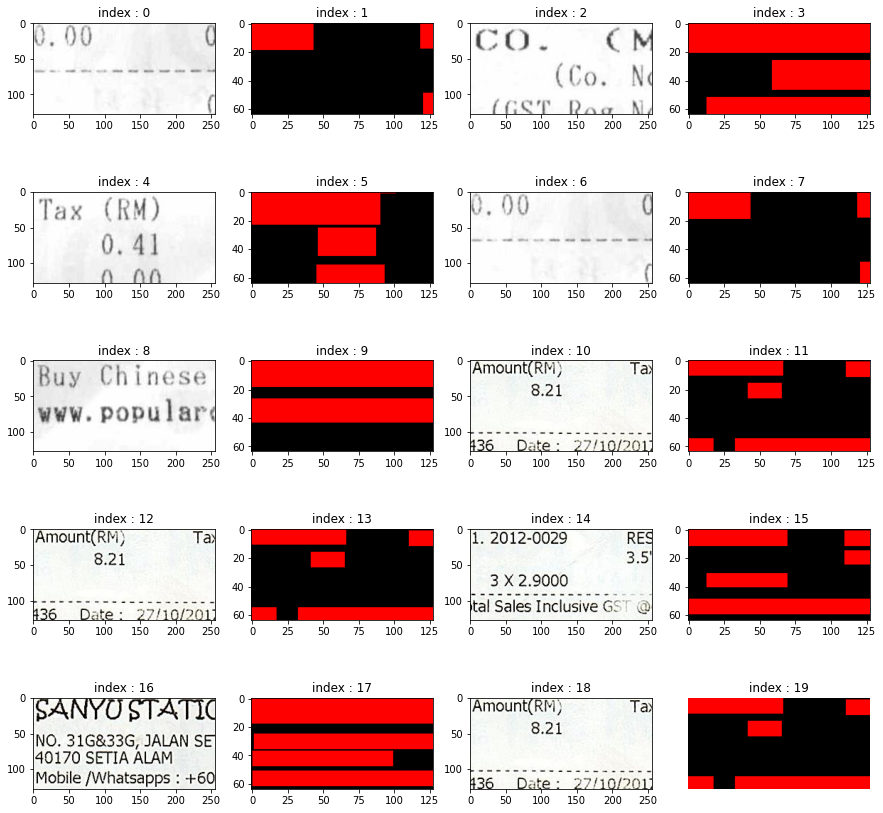

In [458]:
"""
check map images
"""
datadb = open_env(path=common_variable['database']['DB_BASE'] + 'd2gan_train_task12_crop_0100')
imgs = read_bulk_data_from_db(datadb, prefix='img')
char_c = read_bulk_data_from_db(datadb, prefix='char_c')
# print_db(datadb)

"""
show 10 images
"""
vimgs = []
for index in range(len(imgs)):
    img_size = imgs[index].size
    heatmap = get_gaussian1d_heatmap(distanceRatio=1.5)
    lines = char_c[index]
    for idx in range(len(lines)):
        lines[idx][0:8] = list(map(int, lines[idx][0:8]))
    mapimg = compute_word_maps_no_space(heatmap, img_size[1], img_size[0], [lines], descale=2)
    
    vimgs.append(imgs[index])
    vimgs.append(mapimg)


fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
ax = []
for index in range(columns*rows):
    ax.append(fig.add_subplot(rows, columns, index+1) )
    ax[-1].set_title("index : "+str(index))
    plt.imshow(vimgs[index])
plt.axis('off')
plt.show()

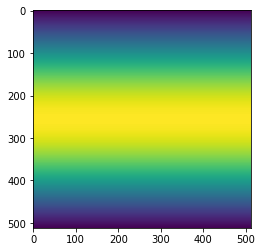

In [459]:
heatmap = get_gaussian1d_heatmap()
plt.imshow(heatmap)